# Droopy Dace Detection

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import asarray
from mtcnn.mtcnn import MTCNN

## Helper Func

In [4]:
BASE_DIR = os.path.abspath(os.getcwd())
train_dir = os.path.join(BASE_DIR+'\stroke-normal_dataset_processed\Train')
val_dir = os.path.join(BASE_DIR+'\stroke-normal_dataset_processed\Test')

def pltCVShow(img):
	img_cvt = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
	plt.imshow(img_cvt)
	plt.show()

## Using Pretrained VGG

In [5]:
NUM_OF_TRAIN_SAMPLES = 1842 
NUM_OF_VAL_SAMPLES = 4171 
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                rotation_range = 20,
                                                                horizontal_flip = True,
                                                                fill_mode = 'wrap')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

Found 1880 images belonging to 2 classes.
Found 4171 images belonging to 2 classes.


In [3]:
for class_name in os.listdir(train_dir):
    class_len = len(os.listdir(os.path.join(train_dir,class_name)))
    print("class "+class_name+f" has {class_len} data for training")

class droopy has 668 data for training
class normal has 1215 data for training


### extract

1/1 [==============================] - 0s 193ms/step


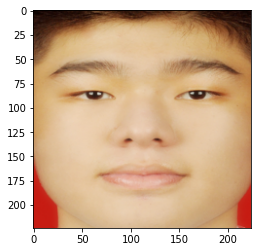

In [4]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = cv2.imread(filename, cv2.COLOR_BGR2RGB)
	pixels = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	return image

# load the photo and extract the face
face_extract = extract_face('3F19DDAA-41C3-47B9-94DF-6BDBFC106751.jpg')
# plot the extracted face
plt.imshow(face_extract)
# show the plot
plt.show()


### preprocessing

In [5]:
CHANNELS = 3
HEIGHT = 224
WIDTH = 224
def prepareImg(fileitem):
    try:
        img = extract_face(fileitem)
        image_resized = tf.image.resize(img, [HEIGHT, WIDTH])
        image_normalized = image_resized / 255.0
        image_for_model = np.expand_dims(image_normalized, axis=0)
    except:
        im = cv2.imread(fileitem)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        image_resized = tf.image.resize(im, [HEIGHT, WIDTH])
        image_normalized = image_resized / 255.0
        image_for_model = np.expand_dims(image_normalized, axis=0)
    return image_for_model

def prepareDataset(fileitem):
    im = cv2.imread(fileitem)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_resized = tf.image.resize(im, [HEIGHT, WIDTH])
    image_normalized = image_resized / 255.0
    image_for_model = np.expand_dims(image_normalized, axis=0)
    return image_for_model


### create model

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 
pre_trained_model = tf.keras.applications.MobileNetV2(weights='imagenet', 
                                                  include_top=False,
                                                  input_shape = (WIDTH, HEIGHT, CHANNELS),
                                                  classifier_activation='softmax')
pre_trained_model.trainable = False
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [9]:
def output_of_last_layer(model,layer_name):
  if(layer_name == ''):
      return model.output
  last_desired_layer = model.get_layer(layer_name)
  # print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  # print('last layer output: ', last_output)

  return last_output

In [10]:
inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, CHANNELS))
inputs = preprocess_input(inputs)
base_model = tf.keras.Model(pre_trained_model.input, output_of_last_layer(pre_trained_model,''))
x = base_model(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Convolution2D(64,3, padding = 'same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Convolution2D(128,3, padding = 'same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Convolution2D(256,3, padding = 'same', activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.layers.Model(inputs=inputs, outputs=x)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 7, 7, 1280)        2257984   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 64)          737344    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 128)         7385

In [38]:
CHECKPOINT_PATH = os.path.join(BASE_DIR, "model_checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH+'\chk.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [55]:
history_train = model.fit(train_generator,steps_per_epoch=NUM_OF_TRAIN_SAMPLES // BATCH_SIZE, epochs=25, validation_data=validation_generator,validation_steps=NUM_OF_VAL_SAMPLES // BATCH_SIZE, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/25
57/57 [==============================] - 25s 430ms/step - loss: 0.1202 - accuracy: 0.9575 - val_loss: 0.0929 - val_accuracy: 0.9656
Epoch 2/25
57/57 [==============================] - 24s 430ms/step - loss: 0.1096 - accuracy: 0.9647 - val_loss: 0.3496 - val_accuracy: 0.8945
Epoch 3/25
57/57 [==============================] - 24s 425ms/step - loss: 0.0808 - accuracy: 0.9735 - val_loss: 0.1056 - val_accuracy: 0.9546
Epoch 4/25
57/57 [==============================] - 23s 404ms/step - loss: 0.0768 - accuracy: 0.9746 - val_loss: 0.3081 - val_accuracy: 0.9079
Epoch 5/25
57/57 [==============================] - 24s 414ms/step - loss: 0.0848 - accuracy: 0.9663 - val_loss: 0.2194 - val_accuracy: 0.9214
Epoch 6/25
57/57 [==============================] - 23s 411ms/step - loss: 0.0762 - accuracy: 0.9768 - val_loss: 0.1495 - val_accuracy: 0.9478
Epoch 7/25
57/57 [==============================] - 25s 443ms/step - loss: 0.0527 - accuracy: 0.9790 - val_loss: 0.2419 - val_accuracy: 0.9413

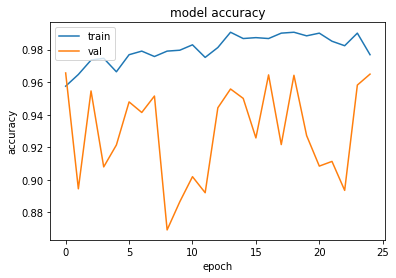

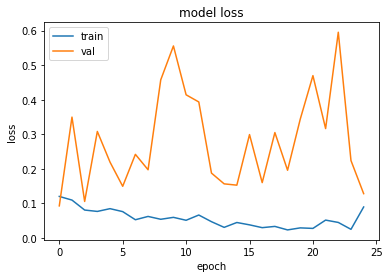

In [56]:
plt.figure()
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Loads the weights
model.load_weights(CHECKPOINT_PATH+'\chk.h5')

# Re-evaluate the model
loss, acc = model.evaluate(train_generator, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Restored model, val_accuracy: {:5.2f}%".format(100 * acc))

58/58 [==============================] - 21s 331ms/step - loss: 0.2898 - accuracy: 0.8796
Restored model, accuracy: 87.96%
131/131 [==============================] - 6s 44ms/step - loss: 0.0761 - accuracy: 0.9791
Restored model, val_accuracy: 97.91%


#####
Busted af doesnot work

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
y_pred = []
for fpath in validation_generator.filenames:
    cur_path = os.path.join(BASE_DIR+"\\"+'stroke-normal_dataset_processed\Test',fpath)
    im = prepareDataset(cur_path)
    val = model.predict(im,verbose = 0)
    if(val<0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['droopy', 'normal']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  82   20]
 [  75 3994]]
Classification Report
              precision    recall  f1-score   support

      droopy       0.52      0.80      0.63       102
      normal       1.00      0.98      0.99      4069

    accuracy                           0.98      4171
   macro avg       0.76      0.89      0.81      4171
weighted avg       0.98      0.98      0.98      4171



In [234]:
counter = 0
for i in range(len(train_generator.labels[:922])):
    if train_generator.labels[i] == y_pred[i]:
        continue
    else:
        counter+=1
print('Number of misclassified images: ', counter)

Number of misclassified images:  258


### Prediction

#### By Dataset

#### by manual

1/1 [==============================] - 0s 104ms/step


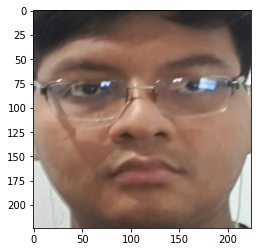

Droopy Confidence 84.367870 %


In [66]:
# convert one face into samples
# filepath = os.path.join(BASE_DIR+"\\"+'stroke-normal_dataset_processed\Train\droopy\\a-39-215x300.jpg')
filepath = os.path.join(BASE_DIR+'\\622351.jpg')
im = prepareImg(filepath)
plt.imshow(im[0])
plt.show()
prediction = model.predict(im,verbose = 0)
if (prediction[0]< 0.5):
    # print("Droopy Confidence {:02f}".format(prediction[0][0]))
    print("Droopy Confidence {:02f} %".format((1-prediction[0][0]*2)*100))
else:
    # print("Droopy Confidence {:02f}".format(prediction[0][0]))
    print("Normal Confidence {:02f} %".format((prediction[0][0])*100))

## Using Face Landmark

In [6]:
train_paths = []
validation_paths = []
for classes in os.listdir(BASE_DIR+"\\"+'stroke-normal_dataset_processed\Train'):
    for data in os.listdir(os.path.join('stroke-normal_dataset_processed\Train',classes)):
        if not (data.endswith('.jpg') or data.endswith('.PNG') or data.endswith('.png') or data.endswith('.jpeg')):
            print(data)
            continue
        if classes == 'droopy':
            train_paths.append((0,os.path.join('stroke-normal_dataset_processed\Train',classes,data)))
        elif classes == 'normal':
            train_paths.append((1,os.path.join('stroke-normal_dataset_processed\Train',classes,data)))
for classes in os.listdir(BASE_DIR+"\\"+'stroke-normal_dataset_processed\Test'):
    for data in os.listdir(os.path.join('stroke-normal_dataset_processed\Test',classes)):
        if not (data.endswith('.jpg') or data.endswith('.PNG') or data.endswith('.png') or data.endswith('.jpeg')):
            print(data)
            continue
        if classes == 'droopy':
            validation_paths.append((0,os.path.join('stroke-normal_dataset_processed\Test',classes,data)))
        elif classes == 'normal':
            validation_paths.append((1,os.path.join('stroke-normal_dataset_processed\Test',classes,data)))

Bellspalsy.JPG
5e88112e-9d7e-4854-908a-541ff3516a69.JPG
IMG_2936.HEIC
IMG_8304.HEIC
IMG_8366.HEIC


In [7]:
print(f"train len {len(train_paths)}")
print(f"val len {len(validation_paths)}")

train len 1878
val len 4171


In [8]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
x_train, x_test, y_train, y_test = [], [], [], []

def clearLandmark(data):
    cleaned_data = []
    for i in range(len(data.landmark)):
        valx = data.landmark[i].x
        valy = data.landmark[i].y
        valz = data.landmark[i].z
        cleaned_data.append([valx,valy,valz])
    return cleaned_data
    
drawing_spec = mp_drawing.DrawingSpec(thickness=3, circle_radius=4)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  for idx, file in enumerate(train_paths):
    image = cv2.imread(file[1])
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
      x_train.append(clearLandmark(face_landmarks))
      y_train.append(file[0])
  for idx, file in enumerate(validation_paths):
    image = cv2.imread(file[1])
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
      x_test.append(clearLandmark(face_landmarks))
      y_test.append(file[0])

In [9]:
print(f"train len {len(x_train)}")
print(f"with droopy = {len([x for x in y_train if x == 0])} normal = {len([x for x in y_train if x == 1])}")
print(f"val len {len(x_test)}")
print(f"with droopy = {len([x for x in y_test if x == 0])} normal = {len([x for x in y_test if x == 1])}")

train len 1851
with droopy = 659 normal = 1192
val len 4057
with droopy = 119 normal = 3938


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(16, 3, padding='SAME', activation='relu',input_shape=(len(face_landmarks.landmark),3)),
    tf.keras.layers.Conv1D(32, 3, padding='SAME', activation='relu'),
    tf.keras.layers.Conv1D(64, 3, padding='SAME', activation='relu'),
    tf.keras.layers.Conv1D(64, 3, padding='SAME', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 478, 16)           160       
                                                                 
 conv1d_5 (Conv1D)           (None, 478, 32)           1568      
                                                                 
 conv1d_6 (Conv1D)           (None, 478, 64)           6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 478, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 30592)             0         
                                                                 
 dropout_1 (Dropout)         (None, 30592)             0         
                                                                 
 dense_3 (Dense)             (None, 32)               

In [12]:
CHECKPOINT_PATH = os.path.join(BASE_DIR, "model_checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH+'\landmark_base.h5',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [14]:
history_train = model.fit(x_train,y_train, epochs=100, validation_data=(x_test,y_test), verbose=1, callbacks=[model_checkpoint_callback])
model.load_weights(CHECKPOINT_PATH+'\landmark_base.h5')
model.save(CHECKPOINT_PATH+'\landmark_base.h5')

Epoch 1/100
58/58 [==============================] - 27s 353ms/step - loss: 0.6525 - accuracy: 0.6418 - val_loss: 0.4627 - val_accuracy: 0.9707
Epoch 2/100
58/58 [==============================] - 1s 13ms/step - loss: 0.6135 - accuracy: 0.6467 - val_loss: 0.4217 - val_accuracy: 0.8740
Epoch 3/100
58/58 [==============================] - 1s 13ms/step - loss: 0.5858 - accuracy: 0.6715 - val_loss: 0.3308 - val_accuracy: 0.9330
Epoch 4/100
58/58 [==============================] - 1s 13ms/step - loss: 0.5615 - accuracy: 0.7083 - val_loss: 0.3739 - val_accuracy: 0.8467
Epoch 5/100
58/58 [==============================] - 1s 12ms/step - loss: 0.5583 - accuracy: 0.6975 - val_loss: 0.4852 - val_accuracy: 0.6638
Epoch 6/100
58/58 [==============================] - 1s 14ms/step - loss: 0.5422 - accuracy: 0.7266 - val_loss: 0.4683 - val_accuracy: 0.7545
Epoch 7/100
58/58 [==============================] - 1s 14ms/step - loss: 0.5344 - accuracy: 0.7347 - val_loss: 0.3277 - val_accuracy: 0.8667
Epoc

In [15]:
model = tf.keras.models.load_model(os.path.join(CHECKPOINT_PATH, 'landmark_base.h5'))

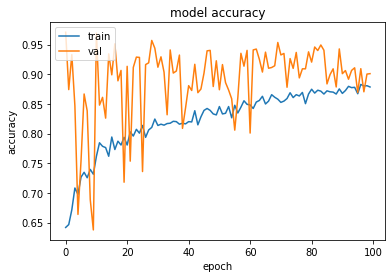

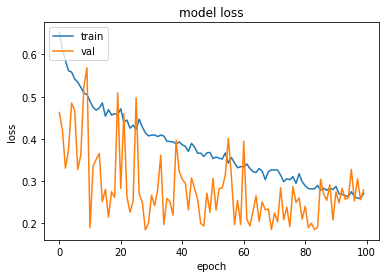

In [16]:
plt.figure()
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prediction

In [17]:
def getFaceLandmark(fileitem):
    with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
        image = cv2.imread(fileitem)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
          return None
        for face_landmarks in results.multi_face_landmarks:
          landmark = clearLandmark(face_landmarks)
    return landmark

#### CF Matrix

##### Train

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

def classified(x):
    if x<0.5:
        return 0
    else:
        return 1
        
y_pred = []
prediction = model.predict(x_train,verbose = 0)
y_pred = [classified(x) for x in prediction]
cm = confusion_matrix(y_train, y_pred)
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(cmn, annot=True, fmt='.2f')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show(block=False)
print('Confusion Matrix')
print(cm)
print('Classification Report')
target_names = ['droopy', 'normal']
print(classification_report(y_train, y_pred, target_names=target_names))

Confusion Matrix
[[ 529  130]
 [  73 1119]]
Classification Report
              precision    recall  f1-score   support

      droopy       0.88      0.80      0.84       659
      normal       0.90      0.94      0.92      1192

    accuracy                           0.89      1851
   macro avg       0.89      0.87      0.88      1851
weighted avg       0.89      0.89      0.89      1851



##### Test

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = []
prediction = model.predict(x_test,verbose = 0)
y_pred = [classified(x) for x in prediction]
cm = confusion_matrix(y_test, y_pred)
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(cmn, annot=True, fmt='.2f')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show(block=False)
print('Confusion Matrix')
print(cm)
print('Classification Report')
target_names = ['droopy', 'normal']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[  74   45]
 [ 323 3615]]
Classification Report
              precision    recall  f1-score   support

      droopy       0.19      0.62      0.29       119
      normal       0.99      0.92      0.95      3938

    accuracy                           0.91      4057
   macro avg       0.59      0.77      0.62      4057
weighted avg       0.96      0.91      0.93      4057



#### Input Prediction

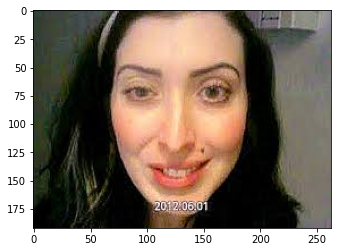

Droopy Confidence 42.896378 %


In [27]:
filepath = os.path.join(BASE_DIR,'baru.jfif')
im = cv2.imread(filepath)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image_landmark = getFaceLandmark(filepath)
image_for_model = np.expand_dims(image_landmark, axis=0)
plt.imshow(im)
plt.show()
prediction = model.predict(image_for_model,verbose = 0)
baseline = 0.5
if (prediction[0][0]< baseline):
    # print("Droopy Confidence {:02f}".format(prediction[0][0]))
    print("Droopy Confidence {:02f} %".format((1-(prediction[0][0]/(baseline-0)))*100))
else:
    # print("Droopy Confidence {:02f}".format(prediction[0][0]))
    print("Normal Confidence {:02f} %".format((((prediction[0][0]-baseline)/(1-baseline)))*100))